In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
def load_data_no_folds(scenario_dir_path, dataset_type):
    # make dict to store data
    storage_list = list()
    # make paths for the specified dataset
    train_annotations_dir = Path(scenario_dir_path, dataset_type, "annotations")
    train_physiology_dir = Path(scenario_dir_path, dataset_type, "physiology")
    # sort contents of dirs, so that physiology and annotations are in the same order  
    train_physiology_files = sorted(Path(train_physiology_dir).iterdir())
    train_annotation_files = sorted(Path(train_annotations_dir).iterdir())
    # iterate over annotation and physiology files
    for physiology_file_path, annotations_file_path in zip(train_physiology_files, train_annotation_files):
        # make sure that we load corresponding physiology and annotations
        assert physiology_file_path.name == annotations_file_path.name, "Order mismatch"
        # load data from files
        df_physiology = pd.read_csv(physiology_file_path, index_col="time")
        df_annotations = pd.read_csv(annotations_file_path, index_col="time")
        # store data
        storage_list.append((annotations_file_path.name, df_physiology, df_annotations))
    return storage_list

In [3]:
def load_data_with_folds(scenario_dir_path, dataset_type):
    # make dict to store data
    storage_dict = dict()
    # iterate over the scenario directory
    for fold_dir in Path(scenario_dir_path).iterdir():
        # make paths for current fold
        train_annotations_dir = Path(fold_dir, f"{dataset_type}/annotations/")
        train_physiology_dir = Path(fold_dir, f"{dataset_type}/physiology/")
        # make key in a dict for current fold 
        storage_dict.setdefault(fold_dir.name, list())
        # sort contents of dirs, so that physiology and annotations are in the same order  
        train_physiology_files = sorted(Path(train_physiology_dir).iterdir())
        train_annotation_files = sorted(Path(train_annotations_dir).iterdir())
        # iterate over annotation and physiology files
        for physiology_file_path, annotations_file_path in zip(train_physiology_files, train_annotation_files):
            # make sure that we load corresponding physiology and annotations
            assert physiology_file_path.name == annotations_file_path.name, "Order mismatch"
            # load data from files
            df_physiology = pd.read_csv(physiology_file_path, index_col="time")
            df_annotations = pd.read_csv(annotations_file_path, index_col="time")
            # store data
            storage_dict[fold_dir.name].append((annotations_file_path.name, df_physiology, df_annotations))
    return storage_dict

In [4]:
import matplotlib.pyplot as plt

def plot_data(modality, annotations, physiology, test=False):
    fig = plt.figure(figsize=(16,8))
    fig.patch.set_facecolor('white')
    # plot train physiology with annotations range 
    plt.subplot(211)
    plt.plot(physiology.index, physiology[modality])
    plt.axvspan(annotations.index[0], annotations.index[-1], color='green', alpha=0.3)
    plt.xlim(left=physiology.index[0], right=physiology.index[-1])
    plt.title(f"{test * 'Test' + (not test) * 'Training'} data", fontsize=20)
    plt.ylabel("Signal value", fontsize=16)
    plt.xlabel("Time", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plot train annotations
    plt.subplot(212)
    plt.plot(annotations.index, annotations['arousal'], label='arousal - train')
    plt.plot(annotations.index, annotations['valence'], label='valence - train')
    plt.xlim(left=physiology.index[0], right=physiology.index[-1])
    plt.legend(fontsize=14)
    plt.ylabel("Annotation value", fontsize=16)
    plt.xlabel("Time", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [5]:
import neurokit2 as nk

def plot_eda(data, fs=1000):
    # Process the raw EDA signal
    preprocess = nk.eda_clean(data, sampling_rate=fs)
    signals, info = nk.eda_process(preprocess, sampling_rate=fs)
    # Extract clean EDA and SCR features
    cleaned = signals["EDA_Phasic"]
    features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]
    # Visualize SCR features in cleaned EDA signal
    plot = nk.events_plot(features, cleaned, color=['red', 'blue', 'orange'])

---

In [7]:
# specify scenario path
scenario_dir = "../data/scenario_1"

# train data
print("Loading train data")
train = load_data_no_folds(scenario_dir, "train")

# test data
print("Loading test data")
test = load_data_no_folds(scenario_dir, "test")

Loading train data
Loading test data


In [8]:
[name, data, label] = train[2]
name, data, label

('sub_11_vid_11.csv',
          ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  emg_trap
 time                                                                      
 0      0.734  36.641  41.599  34.773  25.758     6.549     6.467   148.886
 1      0.754  36.450  41.606  34.773  25.761     6.508     6.548   158.771
 2      0.738  36.583  41.591  34.763  25.761     6.427     6.508   172.897
 3      0.712  36.699  41.653  34.763  25.761     6.385     6.467   185.928
 4      0.672  36.767  41.603  34.754  25.757     6.425     6.467   193.661
 ...      ...     ...     ...     ...     ...       ...       ...       ...
 75046  0.760  36.379  36.496  37.512  25.694     5.480     6.714    27.780
 75047  0.757  36.668  36.508  37.522  25.691     5.400     6.754    27.700
 75048  0.764  36.163  36.430  37.531  25.691     5.480     6.754    27.658
 75049  0.770  36.273  36.430  37.532  25.698     5.440     6.714    27.455
 75050  0.761  36.370  36.437  37.532  25.698     5.399     6.713 

(10.0, 30.0)

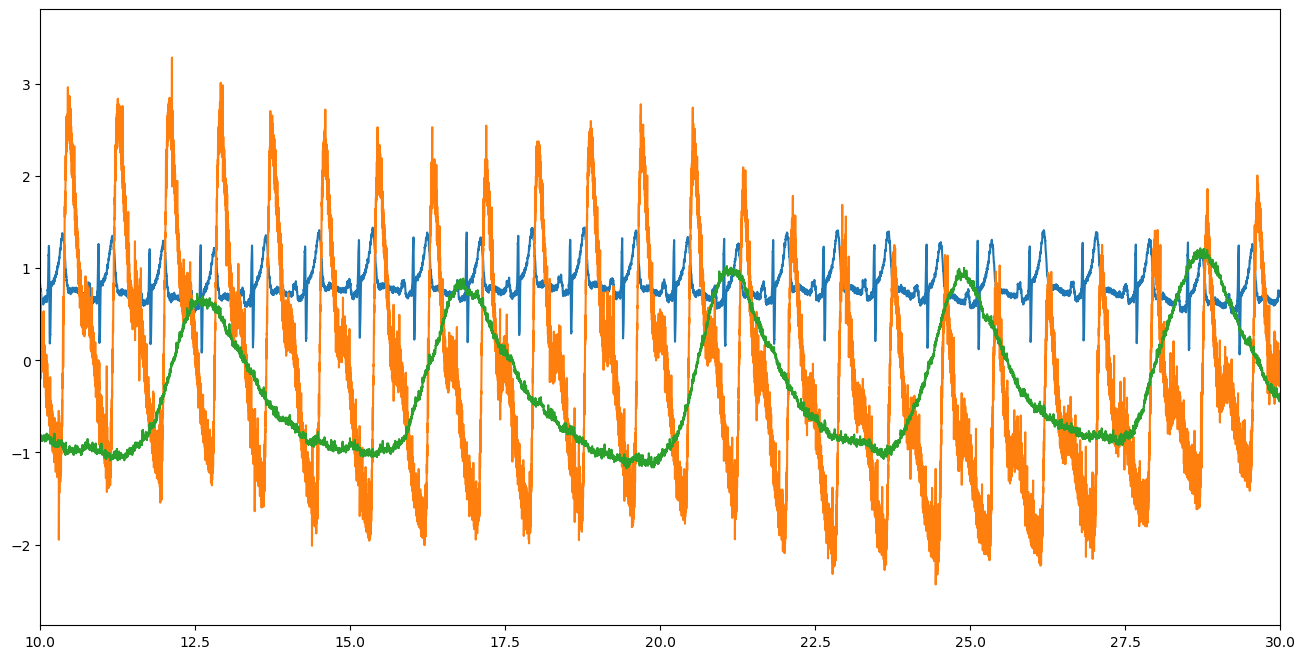

In [8]:
t = np.linspace(0, len(data)/1000, len(data))
plt.figure(figsize=[16,8])
plt.plot(t, data.ecg)
plt.plot(t, data.bvp - data.bvp.mean())
plt.plot(t, data.rsp -data.rsp.mean())
# plt.plot(t,data.gsr)
# plt.plot(t,data.skt)
# plt.plot(t,data.emg_trap)
# plt.plot(t,data.emg_zygo)
# plt.plot(t,data.emg_coru)

plt.xlim([10, 30])

/Users/felixdollack/miniconda3/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


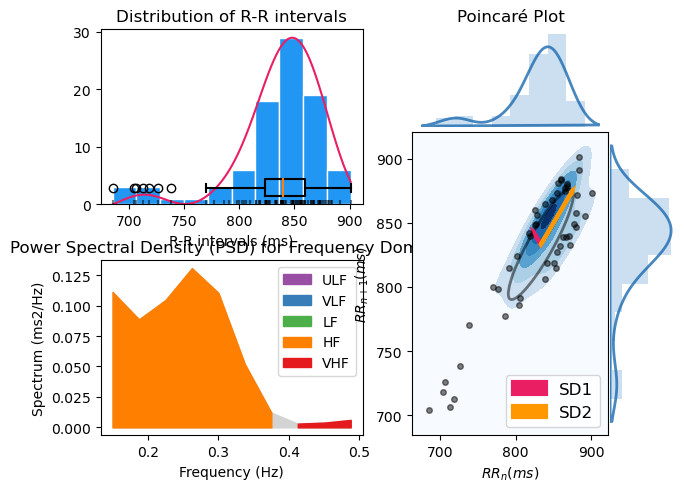

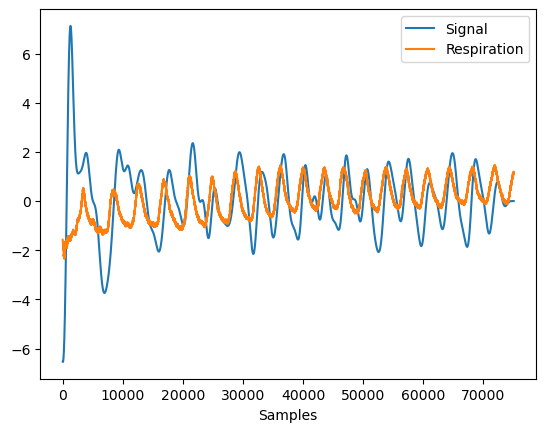

In [9]:
ecg = data.ecg.values

# Extract peaks
rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=1000)

# Compute rate
ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg))
edr = nk.ecg_rsp(ecg_rate, sampling_rate=1000, method="sarkar2015")

# Extract clean EDA and SCR features
hrv_freq = nk.hrv(rpeaks, sampling_rate=1000, show=True)

# Visual comparison
nk.signal_plot(edr)
plt.plot(np.array(list(range(len(data)))), data.rsp -data.rsp.mean(), label="Respiration")
plt.legend()

In [10]:
fs = 1000
winLen = int(2.5 * fs)
epochs = nk.epochs_create(
    data,
    list(range(0,len(data)-winLen, winLen)),
    sampling_rate=fs,
    epochs_start=0,
    epochs_end=winLen
)

In [11]:
df_epochs = nk.epochs_to_df(epochs)

In [12]:
df_epochs.head()

,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,Index,Label,Time
0,0.734,36.641,41.599,34.773,25.758,6.549,6.467,148.886,0,1,0.000
1,0.754,36.450,41.606,34.773,25.761,6.508,6.548,158.771,1,1,0.001
2,0.738,36.583,41.591,34.763,25.761,6.427,6.508,172.897,2,1,0.002
3,0.712,36.699,41.653,34.763,25.761,6.385,6.467,185.928,3,1,0.003
4,0.672,36.767,41.603,34.754,25.757,6.425,6.467,193.661,4,1,0.004


In [ ]:
proc = nk.eda_process(df_epochs, sampling_rate=fs)

In [14]:
analyzed = nk.eda_analyze(df_epochs, sampling_rate=1000, method='event-related')

/Users/felixdollack/miniconda3/lib/python3.10/site-packages/neurokit2/epochs/eventrelated_utils.py:30: NeuroKitWarning: eda_eventrelated(): The duration of your epochs seems quite long. You might want to use eda_intervalrelated().
  warn(
/Users/felixdollack/miniconda3/lib/python3.10/site-packages/neurokit2/eda/eda_eventrelated.py:134: NeuroKitWarning: Input does not have an `EDA_Phasic` column. Will skip computation of maximum amplitude of phasic EDA component.
  warn(


KeyError: 'SCR_Peaks'

In [41]:
proc

,Signal,Index,Label,Time
0,0.734,0,1,0.000
1,0.754,1,1,0.001
2,0.738,2,1,0.002
3,0.712,3,1,0.003
4,0.672,4,1,0.004
...,...,...,...,...
74999995,0.000,2572495,30,2499.996
74999996,0.000,2572496,30,2499.997
74999997,0.000,2572497,30,2499.998
74999998,0.000,2572498,30,2499.999


### Look at all the GSR data and their ratings

In [ ]:
for (name, data, label) in train:
    print(name)
    plot_data('gsr', label, data, test=False)
    plt.figure()
    plot_eda(data.gsr)
    plt.show()

### Extract video numbers and order from all loaded data

This allows us to look at data per video to identify potential similarities.

In [ ]:
sub_vid = list()

for (name, data, label) in train:
    parts = name.split('_')
    sub_vid.append(
        (
            int(parts[1]), # get participant number
            int(parts[-1].split('.')[0])) # get video number
    )

df = pd.DataFrame(sub_vid, columns=['participant', 'video'])
videos = sorted(df.video.unique())

In [ ]:
for v in videos:
    print(f"Video {v}")
    for idx in df[df.video == v].index:
        (name, data, label) = train[idx]
        print(name)
        plot_data('gsr', label, data, test=False)
        plt.figure()
        plot_eda(data.gsr)
        plt.show()

---

In [ ]:
# specify scenario path
scenario_dir = "../data/scenario_4"

# train data
print("Loading train data")
load_data_with_folds(scenario_dir, "train")

# test data
print("Loading test data")
load_data_with_folds(scenario_dir, "test")